<a href="https://colab.research.google.com/github/rderakhshan/Visualizing_multicollinearity/blob/main/Visualizing_multicollinearity_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Visualizing multicollinearity in Python

## Imports

In [ ]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import networkx as nx
from ipywidgets import Layout, widgets
from google.colab import output
output.enable_custom_widget_manager()
import math
import matplotlib.dates as md

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 6.4 MB 3.9 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Data and mapping

### Retrieving S&P500 tickers

In [ ]:
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
sp500_table = payload[0]
sp500_table

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
...,...,...,...,...,...,...,...,...,...
500,YUM,Yum! Brands,reports,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
501,ZBRA,Zebra,reports,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
502,ZBH,Zimmer Biomet,reports,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
503,ZION,Zions Bancorp,reports,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


### Generate color mappings for similar sectors

In [ ]:
sp500_tickers = sp500_table.Symbol.str.upper().values
sp500_names = sp500_table.Security.values
sp500_sectors = sp500_table["GICS Sector"].values
sp500_sub_sectors = sp500_table["GICS Sub-Industry"].values

sp500_names_mapping = dict(zip(sp500_tickers, sp500_names))
sp500_sector_mapping = dict(zip(sp500_names, sp500_sectors))
sp500_sub_sector_mapping = dict(zip(sp500_names, sp500_sub_sectors))
sector_color_mapping = dict(zip(sp500_sectors, sns.color_palette("pastel", len(sp500_sectors)).as_hex()))
subsector_color_mapping = dict(zip(sp500_sub_sectors, sns.color_palette("pastel", len(sp500_sub_sectors)).as_hex()))

### Download stock data

In [ ]:
tickers = list(sp500_tickers)
prices = yf.download(tickers, start="2020-01-01", end="2021-12-31", interval='1d')
prices = prices["Adj Close"]
prices = prices.rename(columns=sp500_names_mapping)
prices

[*********************100%***********************]  505 of 505 completed

3 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- CEG: Data doesn't exist for startDate = 1577836800, endDate = 1640908800
- BRK.B: No data found, symbol may be delisted


,Agilent Technologies,American Airlines Group,Advance Auto Parts,Apple,AbbVie,AmerisourceBergen,Abiomed,Abbott,Accenture,Adobe,...,Wynn Resorts,Xcel Energy,ExxonMobil,Dentsply Sirona,Xylem,Yum! Brands,Zimmer Biomet,Zebra,Zions Bancorp,Zoetis
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,84.799667,28.982893,155.478271,73.894325,80.137352,82.064140,168.809998,84.001160,203.776093,334.429993,...,142.405029,58.711704,61.174908,56.203197,77.805450,98.132996,142.720795,259.140015,49.020840,132.432312
2020-01-03,83.438148,27.548195,155.488007,73.175911,79.376678,81.032082,166.820007,82.977119,203.436737,331.809998,...,140.292755,58.994064,60.683090,55.581242,78.263412,97.825645,142.347702,256.049988,48.329090,132.452087
2020-01-06,83.684799,27.219410,152.932648,73.759018,80.003113,82.218468,179.039993,83.411850,202.108231,333.709991,...,140.015091,58.909348,61.149014,55.887280,77.756737,97.768013,141.525070,258.010010,47.740173,131.435165
2020-01-07,83.941322,27.119778,151.118500,73.412117,79.546715,81.630096,180.350006,82.948128,197.744766,333.390015,...,140.679504,58.786999,60.648563,56.183449,77.464417,97.940910,141.400726,256.470001,47.450382,131.879471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,157.592438,18.260000,232.130005,176.055695,131.723129,129.109039,352.209991,138.670883,402.267090,569.619995,...,88.879997,66.148552,60.350952,55.430000,117.112770,134.714600,123.051254,582.409973,62.041107,242.121170
2021-12-27,158.531204,18.170000,236.500000,180.100540,133.029587,131.471329,357.829987,140.962799,414.255981,577.679993,...,87.580002,66.357094,61.211414,55.950001,117.900162,137.372253,124.087379,606.330017,62.687782,246.114746
2021-12-28,158.970612,18.540001,238.130005,179.061859,133.009781,131.929840,357.440002,139.976273,414.196136,569.359985,...,86.459999,67.151550,61.013607,56.029999,119.126106,137.342392,124.475731,597.320007,62.787273,243.858383


### Preprocessing (imputation)

In [ ]:
for i, row in prices.iterrows():
  if row.isnull().mean() > 0.9: prices.drop(i, inplace=True)
prices = prices.loc[:, prices.isnull().mean() < 0.3]
prices = prices.fillna(method='bfill')
print(prices.shape)

(504, 501)


### Generate correlation matrix

Note: this can take a while

In [ ]:
corr = prices.rolling(60).corr()
corr_ = np.array([corr.loc[i].to_numpy() for i in prices.index if not np.isnan(corr.loc[i].to_numpy()).all()])
corr_ = np.nansum(corr_, axis=0)/len(corr_)
corr_ = pd.DataFrame(columns=prices.columns.tolist(), index=prices.columns.tolist(), data=corr_)

In [ ]:
corr_.value_counts()

Agilent Technologies  American Airlines Group  Advance Auto Parts  Apple      AbbVie     AmerisourceBergen  Abiomed   Abbott     Accenture  Adobe      Analog Devices  ADM       ADP        Autodesk   Ameren    American Electric Power  AES       Aflac     AIG       Assurant  Gallagher  Akamai     Albemarle  Align      Alaska Air Group  Allstate   Allegion  Applied Materials  Amcor     AMD        Ametek    Amgen      Ameriprise Financial  American Tower  Amazon     Arista     Ansys      Anthem    Aon       A. O. Smith  APA Corporation  Air Products  Amphenol  Aptiv     Alexandria  Atmos Energy  Activision Blizzard  AvalonBay Communities  Broadcom   Avery Dennison  American Water  American Express  AutoZone  Boeing    Bank of America  Baxter    Bath & Body Works  Best Buy  Becton Dickinson  Franklin Templeton  Biogen    Bio-Rad    BNY Mellon  Booking Holdings  Baker Hughes  BlackRock  Ball       Bristol Myers Squibb  Broadridge  Brown & Brown  Boston Scientific  BorgWarner  Boston Properti

## Visualizations

### Approach 1: The heatmap

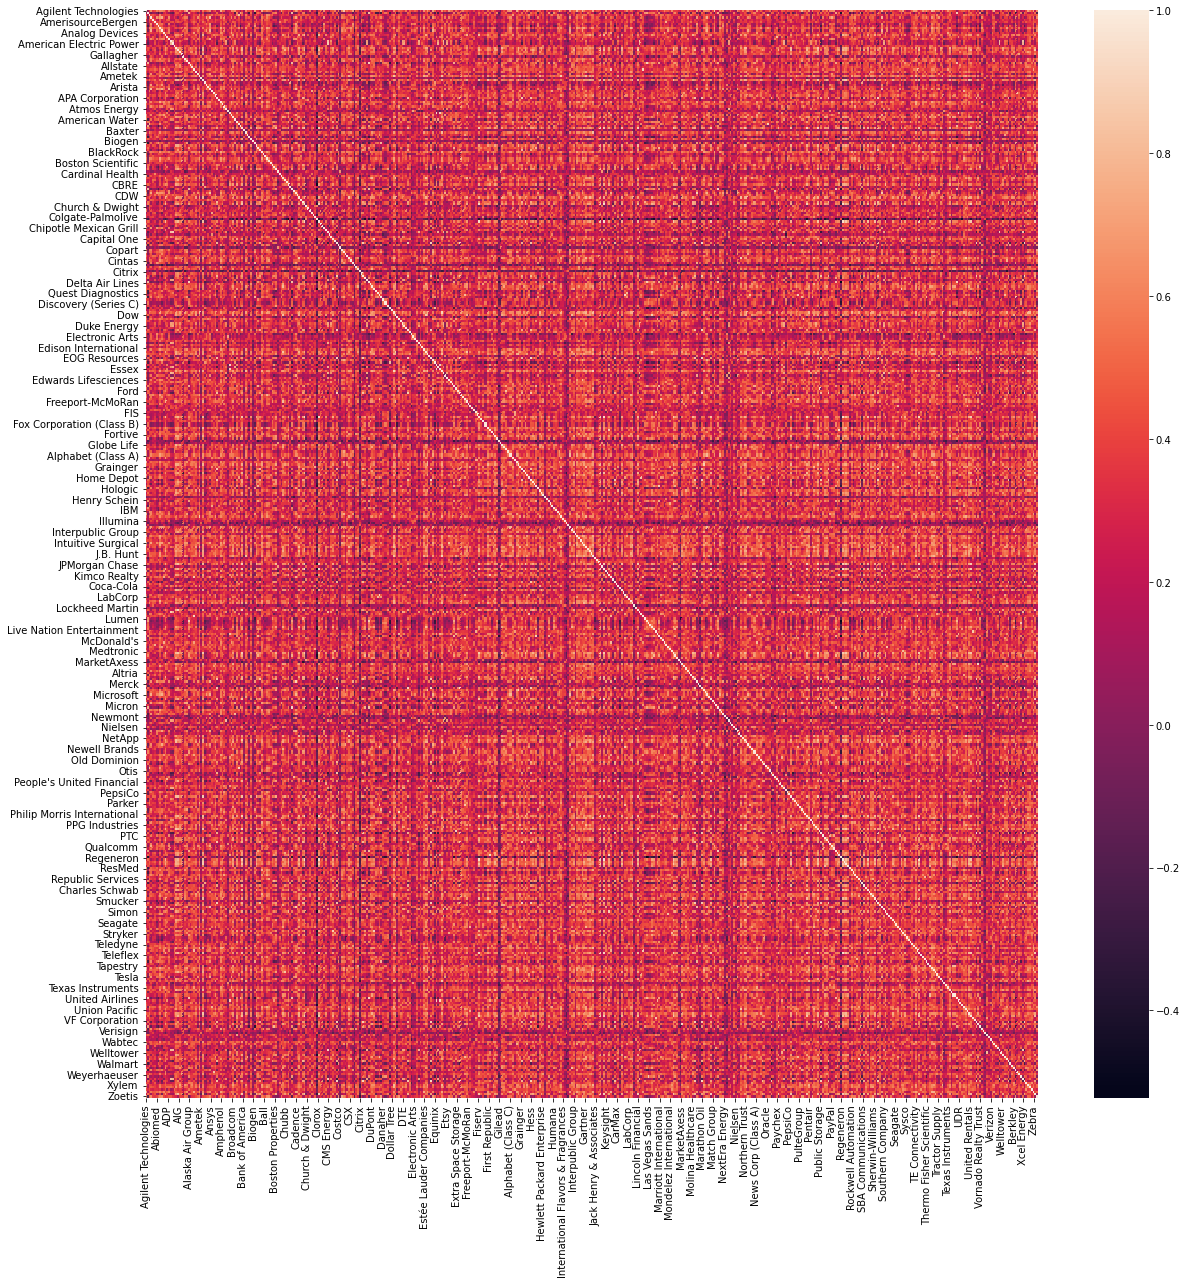

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_) 

### Approach 2: The clustermap

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



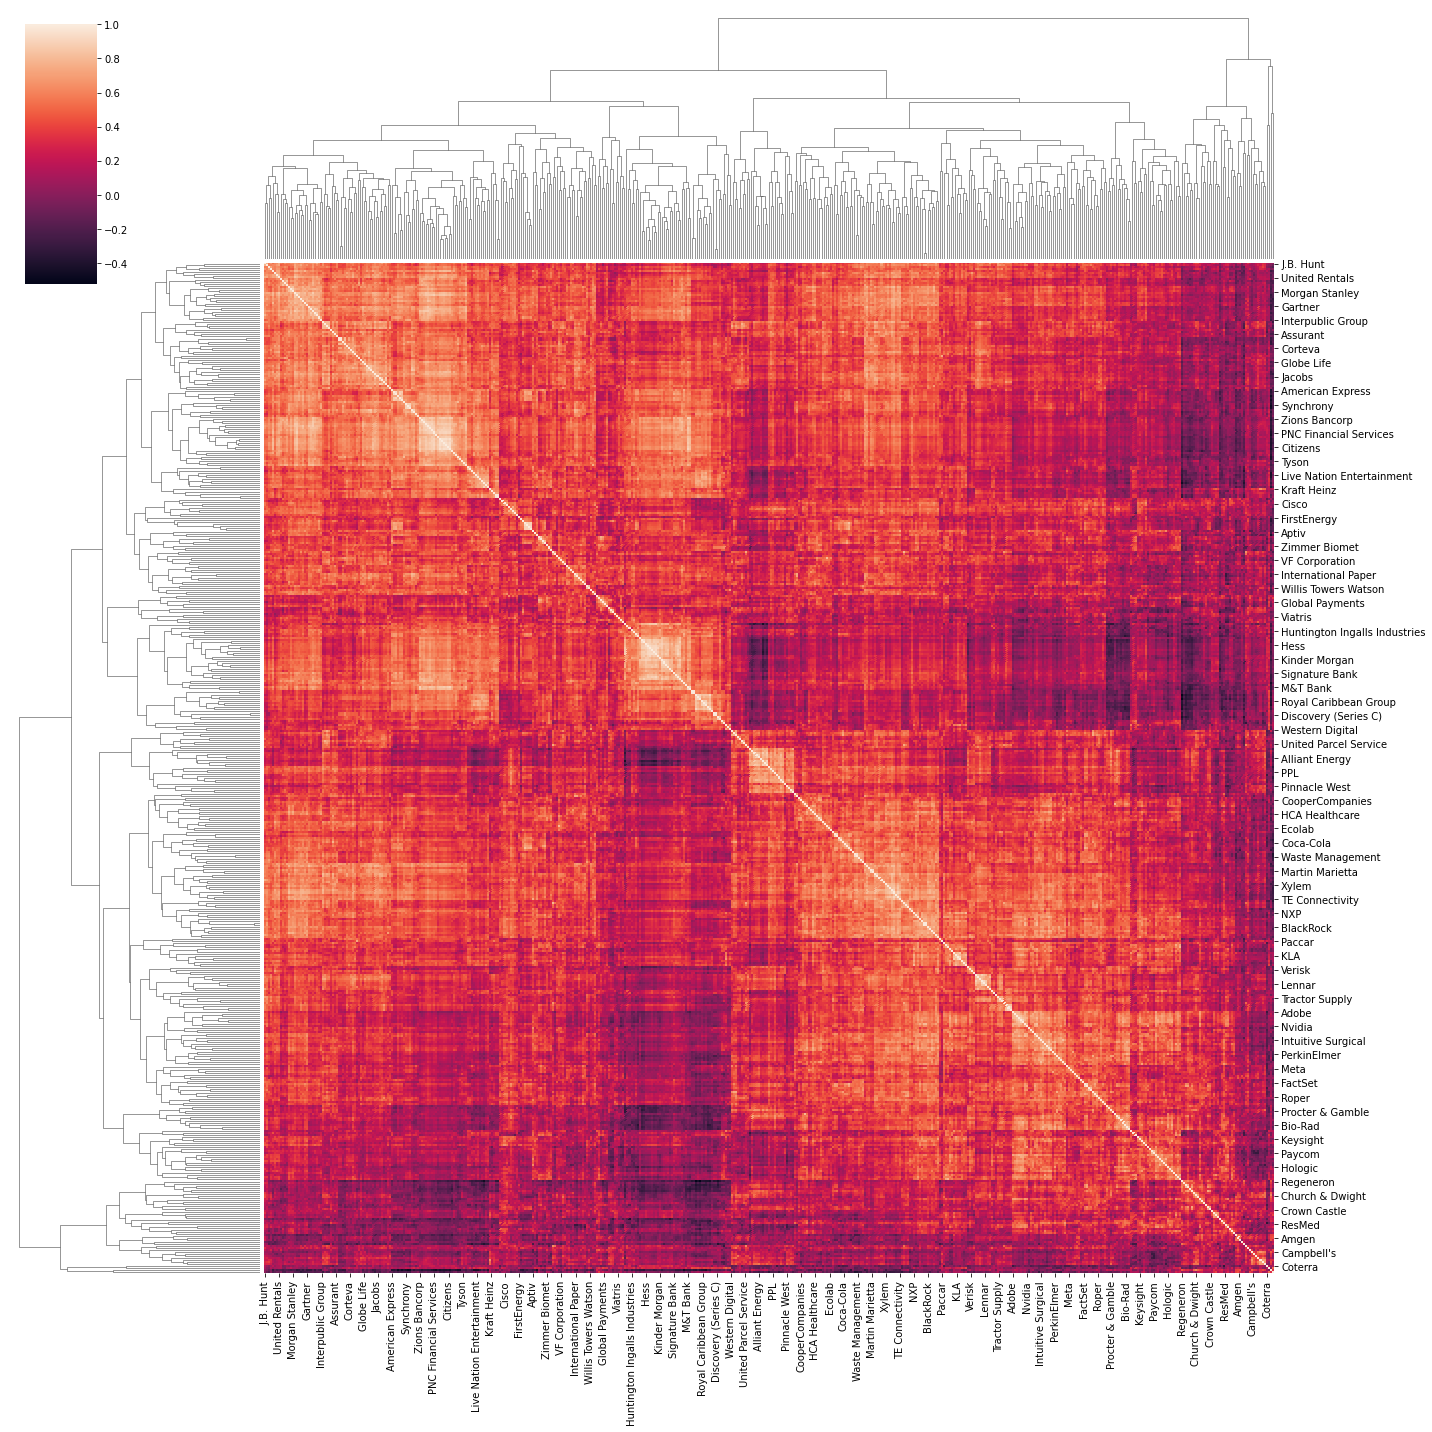

In [ ]:
sns.clustermap(corr_, figsize=(20,20))

### Approach 3: Interactive network graph

In [ ]:
threshold_choice = widgets.FloatSlider(description="Threshold", value=0.8, min=0.5, max=1, step=0.05, continuous_update=False, orientation='horizontal',
                           layout=Layout(width='500px'), style=dict(description_width= 'initial'))

network = go.FigureWidget(data=[go.Scatter(x=[], y=[], mode='lines', text=[],  line=dict(color='MediumPurple',width=10),
                                           marker=dict(size=20, line_width=10,line=dict(color='MediumPurple',width=2))),
                                go.Scatter(x=[], y=[],mode='markers+text', textposition="top center", 
                                          text=[],hoverinfo='text',textfont_size=12, marker=dict(size=50, color=[],line_width=1))],
                          layout=go.Layout( showlegend=False, annotations=[], margin=dict(t=40, b=0, l=0, r=0), width=1600, height=800))

df = prices.copy()
correlation_matrix = corr_.to_numpy()

def plot_corr_graph(change):
    threshold, corr_mode = None, None

    threshold = change.new
    
    tr_ind = np.triu_indices(correlation_matrix.shape[0])
    correlation_matrix[tr_ind] = 0

    G = nx.from_numpy_matrix(correlation_matrix)
    G = nx.relabel_nodes(G, lambda x: df.columns.tolist()[x])
    # 49 x 49 - 49 (self corr) / 2 (remove upper triang)

    remove = []
    
    for col1, col2, weight in G.edges(data=True):

        if math.isnan(weight["weight"]):
            remove.append((col1,col2))
    
        if abs(weight["weight"]) < threshold:
            remove.append((col1,col2))
    
    G.remove_edges_from(remove)
    
    remove = []
    edges = list(sum(G.edges, ()))

    for node in G.nodes:
        if node not in edges:
            remove.append(node)

    G.remove_nodes_from(remove)
    mst = nx.maximum_spanning_tree(G)

    def assign_color(col):
      return sector_color_mapping[sp500_sector_mapping[col]]

    # def assign_thickness(correlation, benchmark_thickness=20, scaling_factor=2):
    #   return benchmark_thickness * abs(correlation)**scaling_factor

    # def assign_node_size(degree, scaling_factor=500):
    #   return degree * scaling_factor

    def assign_color_edge(correlation):
      if correlation < 0:
        return "#BF0603"
      else:
        return "#00CC66"

    edge_colors = []
    # edge_width = []
    # node_size = []
    node_colors = []

    for key, value in nx.get_edge_attributes(mst, 'weight').items():
        edge_colors.append(assign_color_edge(value))
        # edge_width.append(assign_thickness(value))

    for key, value in dict(mst.degree).items():
        # node_size.append(assign_node_size(value))
        node_colors.append(assign_color(key))
      
    labels = {n:n for n in mst.nodes()}
    node_x = []
    node_y = []
    
    tree = nx.fruchterman_reingold_layout(mst, k=0.25).items()
    
    for node, (x_,y_) in tree:
        node_x.append(x_)
        node_y.append(y_)
        
    def get_dim_of_node(name):
        for node, (x,y) in tree:
            if node == name:
                return x,y
        
    edge_x = []
    edge_y = []
    
    weights= []
    for node1, node2, w in mst.edges(data=True):
        x0, y0 = get_dim_of_node(node1)
        x1, y1 =  get_dim_of_node(node2)
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        weights.append((round(w["weight"],1), (x0+x1)/2, (y0+y1)/2))
    # annotations_list =[dict(x=weight[1], y=weight[2], xref='x', yref='y', text=weight[0], ax=weight[1], ay=weight[2]) for weight in weights]
                              
    with network.batch_update():
        network.data[1].x = node_x
        network.data[1].y = node_y
        network.data[1].text = list(labels)
        network.data[1].marker.color = node_colors
        # network.update_layout(annotations=annotations_list)
                          
        network.data[0].x = edge_x
        network.data[0].y = edge_y
        network.data[0].text = list(weights)
        network.update_layout(xaxis_zeroline=False, yaxis_zeroline=False, xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor='rgba(0,0,0,0)')

threshold_choice.observe(plot_corr_graph, names="value")
widgets.VBox([threshold_choice])

Run the cell below and play around with the treshold above to see results. (Threshold of >= 0.9 is recommended)

In [ ]:
network

FigureWidget({
    'data': [{'line': {'color': 'MediumPurple', 'width': 10},
              'marker': {'line': …